# Injected Light Curve Flare Recovery on Long Cadence Light Curves

We use the same method as in notebook #2 do find flares on the injected light curves. We then compare these recovered flares with the injected flares.

- [Flare finding on injected light curves](#Flare-finding-on-injected-light-curves)
- [Cross-matching recovered and injected flares](#Cross-matching-recovered-and-injected-flares)
  - [Method and example](#Method-and-example)
  - [Long Cadence](#lc_cm)

In [1]:
import sys

import numpy as np

from astropy.table import Table, Column, vstack
from astropy.time import Time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('../src')

import arhap
import findflares

## Flare finding on injected light curves

**Note:**  This step takes a few minutes (~5-10). It will also produce some warnings which can be safely ignored.

In [3]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv")

lc_info_table.add_column(Column(name="inj_phivv_stats_path",dtype="U128", length=len(lc_info_table)))
lc_info_table.add_column(Column(name="inj_phivv_fit_params",dtype=float,shape=(5,), length=len(lc_info_table)))
lc_info_table.add_column(Column(name="inj_pval_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="inj_phivv_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="inj_sigma_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="inj_num_flares_auto",dtype=int, length=len(lc_info_table)))

In [4]:
full_flare_table = None

In [6]:
for lc_row in lc_info_table:
        
    # skipping the ones where the detrending failed
    if lc_row['injected_score'] >= 2:
        continue
        
    # Getting the light curve
    lc_table = Table.read(lc_row["injected_path"])
    
    # Performing all the flare finding statistics
    ws_stat_table, _ = findflares.phi_vv_stats(lc_table)
    hist_bins = findflares.get_hist_bins(ws_stat_table['phi_vv'][ws_stat_table['candidates']].max(),
                                         np.abs(ws_stat_table['phi_vv'][ws_stat_table['null_1'] | ws_stat_table['null_2']]).max(),
                                         verbose=False)
    fit_parameters, covariance = findflares.fit_phi_vv_histogram(ws_stat_table, hist_bins, verbose=False)
    findflares.calculate_pvals(ws_stat_table, hist_bins, fit_parameters)
    pval_thresh, thresh = findflares.perform_fdr_analysis(ws_stat_table, alpha=0.1, verbose=False)
    sigma_thresh = findflares.apply_sigma_threshold(lc_table, ws_stat_table, threshold=2.5, 
                                                    verbose=False, remove_artifacts=False)
    
    # Generating the list of flares
    flare_table = findflares.make_flare_list(ws_stat_table, lc_table, padding=0)
    
    phivv_stats_path = lc_row["injected_path"].replace("lc.ecsv","stats.ecsv")
    ws_stat_table.write(phivv_stats_path, format="ascii.ecsv", overwrite=True)
    
    if len(flare_table):
        cols = flare_table.colnames
        flare_table["kid"] = lc_row["KID"]
        flare_table = flare_table[["kid"] + cols]
        
        if full_flare_table is None:
            full_flare_table = flare_table
        else:
            full_flare_table = vstack((full_flare_table, flare_table))
    
    lc_row['inj_phivv_stats_path'] = phivv_stats_path
    lc_row['inj_phivv_fit_params'] = fit_parameters.tolist()
    lc_row['inj_pval_thresh'] = pval_thresh
    lc_row['inj_phivv_thresh'] = thresh
    lc_row['inj_sigma_thresh'] = sigma_thresh
    lc_row['inj_num_flares_auto'] = len(flare_table)

/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in multiply
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWa

/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning

/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning

/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in multiply
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWa

In [7]:
lc_info_table["inj_phivv_fit_params"] = [str(x.tolist()) for x in lc_info_table["inj_phivv_fit_params"]]

lc_info_table.write("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv", overwrite=True)

In [9]:
# Saving the flare list
full_flare_table.write("../data_tables/recovered_injected_flares_longcad.ecsv", format="ascii.ecsv")

## Cross-matching recovered and injected flares

We need to determine which flares we recovered.

### Method and example

In [23]:
info_row = lc_info_table[10]
recovered_flares = full_flare_table[full_flare_table["kid"] == info_row["KID"]]
injected_flares = Table.read(info_row["synth_flare_path"],format="ascii.ecsv")
injected_lc = Table.read(info_row["injected_path"],format="ascii.ecsv")

# We didn't capture the peak time when flare finding, we'll have to rectify that error now.
recovered_flares["peak_time"] = injected_lc[recovered_flares["peak_ind"]]["time"]

In [24]:
injected_flares.add_column(Column(name="recovered",dtype=bool, length=len(injected_flares)))

recovered_flares.add_column(Column(name="inj_f_peak", dtype=float, length=len(recovered_flares)))
recovered_flares.add_column(Column(name="inj_t_12", dtype=float, length=len(recovered_flares)))
recovered_flares.add_column(Column(name="inj_flare_eng", dtype=float, length=len(recovered_flares)))
recovered_flares.add_column(Column(name="inj_flare_t_peak", dtype=Time, length=len(recovered_flares)))

We consider the largest flare between the recovered peak point and its neighbor's as the true "recovered flare."

In [26]:
for row in recovered_flares:
    
    pos_flares = injected_flares[(injected_flares['t_peak'] >= row["peak_time"]-arhap.Kepler_lc_exptime) & 
                                 (injected_flares['t_peak'] <= row["peak_time"]+arhap.Kepler_lc_exptime)]
    
    flare_idx = np.where(injected_flares['flare_eng'] == np.max(pos_flares['flare_eng']))[0]
    if len(flare_idx) > 1:
        print("bad match")
    flare_idx = flare_idx[0]
    orig_flare = injected_flares[flare_idx]
    
    row['inj_f_peak'] = orig_flare['f_peak']
    row['inj_t_12'] = orig_flare['t_12']
    row['inj_flare_eng'] = orig_flare['flare_eng']
    row['inj_flare_t_peak'] = orig_flare['t_peak']
    
    orig_flare["recovered"] = True

Plotting the results shows that we are by and large recovering the largest flares, which is what we expect.

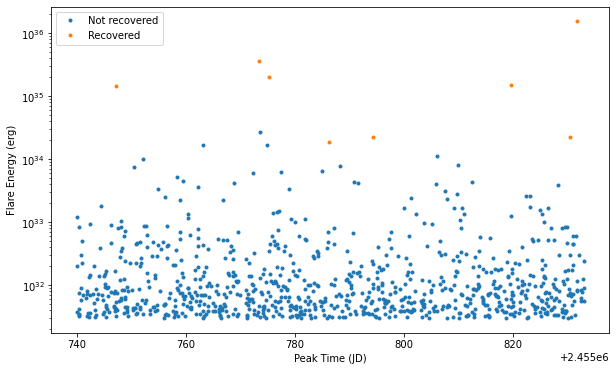

In [28]:
f, ax = plt.subplots(figsize=(10, 6))

ax.plot(injected_flares['t_peak'][~injected_flares['recovered']].jd, 
        injected_flares['flare_eng'][~injected_flares['recovered']], '.', label="Not recovered")
ax.plot(injected_flares['t_peak'][injected_flares['recovered']].jd, 
        injected_flares['flare_eng'][injected_flares['recovered']], '.', label="Recovered")

        
ax.set_xlabel("Peak Time (JD)")
ax.set_ylabel("Flare Energy (erg)")

ax.legend()

ax.semilogy()
        
plt.show()

### Long Cadence  <a id='lc_cm'></a>

We run through the `full_flare_table` star by star and determine which injected flares were recovered. There is surely a clever way of doing this in place, but instead we build a new flare table with the additional information

In [10]:
full_flare_table.add_column(Column(name="inj_f_peak", dtype=float, length=len(full_flare_table)))
full_flare_table.add_column(Column(name="inj_t_12", dtype=float, length=len(full_flare_table)))
full_flare_table.add_column(Column(name="inj_flare_eng", dtype=float, length=len(full_flare_table)))
full_flare_table.add_column(Column(name="inj_flare_t_peak", dtype=Time, length=len(full_flare_table)))

new_full_flare_table = None

In [11]:
for info_row in lc_info_table:

    recovered_flares = full_flare_table[full_flare_table["kid"] == info_row["KID"]]
    
    injected_flares = Table.read(info_row["synth_flare_path"],format="ascii.ecsv")
    
    if "recovered" not in injected_flares.colnames:
        injected_flares.add_column(Column(name="recovered",dtype=bool, length=len(injected_flares)))
    
    injected_lc = Table.read(info_row["injected_path"],format="ascii.ecsv")
    
    # Adding peak time column
    recovered_flares["peak_time"] = injected_lc[recovered_flares["peak_ind"]]["time"]
    
    # Performing the crossmatch
    for row in recovered_flares:
    
        pos_flares = injected_flares[(injected_flares['t_peak'] >= row["peak_time"]-arhap.Kepler_lc_exptime) & 
                                     (injected_flares['t_peak'] <= row["peak_time"]+arhap.Kepler_lc_exptime)]
        
        if len(pos_flares) == 0:
            continue
    
        flare_idx = np.where(injected_flares['flare_eng'] == np.max(pos_flares['flare_eng']))
        #print(flare_idx)
        if len(flare_idx) > 1:
            print("bad match")
        flare_idx = flare_idx[0][0]
        orig_flare = injected_flares[flare_idx]
    
        row['inj_f_peak'] = orig_flare['f_peak']
        row['inj_t_12'] = orig_flare['t_12']
        row['inj_flare_eng'] = orig_flare['flare_eng']
        row['inj_flare_t_peak'] = orig_flare['t_peak']
    
        orig_flare["recovered"] = True
    
    # Saving the results
    if not new_full_flare_table:
        new_full_flare_table = recovered_flares
    else:
        new_full_flare_table = vstack((new_full_flare_table, recovered_flares))
        
    injected_flares.write(info_row["synth_flare_path"], format="ascii.ecsv", overwrite=True)

In [12]:
# make sure the whole injected flare t_peak column is a time object
# Ignore the warning, it's just because "0" is a dubious jd time
new_full_flare_table["inj_flare_t_peak"] = Time([x if x != 0 else Time(0,format='jd') for x in new_full_flare_table["inj_flare_t_peak"]])

# write the new full flare table
new_full_flare_table.write("../data_tables/recovered_injected_flares_longcad.ecsv", format="ascii.ecsv", overwrite=True)

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
